# SMS Spam or Ham Classifier using NLP

This notebook presents a **Natural Language Processing (NLP)** approach to classify SMS messages as either *spam* or *ham* (non-spam). The aim is to develop a model that can accurately distinguish between spam and ham messages based on their content.

### Overview:
- **Problem Statement**: With the rise of SMS communication, detecting and filtering out spam messages is crucial to maintain user privacy and prevent potential scams.
- **Goal**: Build a machine learning model that identifies spam SMS messages using NLP techniques.

Let's dive into the world of **NLP** and **SMS classification** to build a robust classifier that can safeguard users from unwanted spam messages!

## IMPORTING LIBRARIES



In [ ]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

## LOADING DATA

In [ ]:
#Loading data
data = pd.read_csv("/content/spam.csv",encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# Dropping unused columns
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The dataset contains a total of 5,572 English SMS messages, each labeled as either **ham** (non-spam) or **spam**. The dataset is organized into a DataFrame with two columns:
- **Target**: Indicates whether the message is classified as *ham* or *spam*.
- **Text**: Contains the actual content of the SMS message.

This clear structure allows for efficient analysis and model training for spam detection.

## DATA EXPLORATION



Text(0, 0.5, 'Number of Data points')

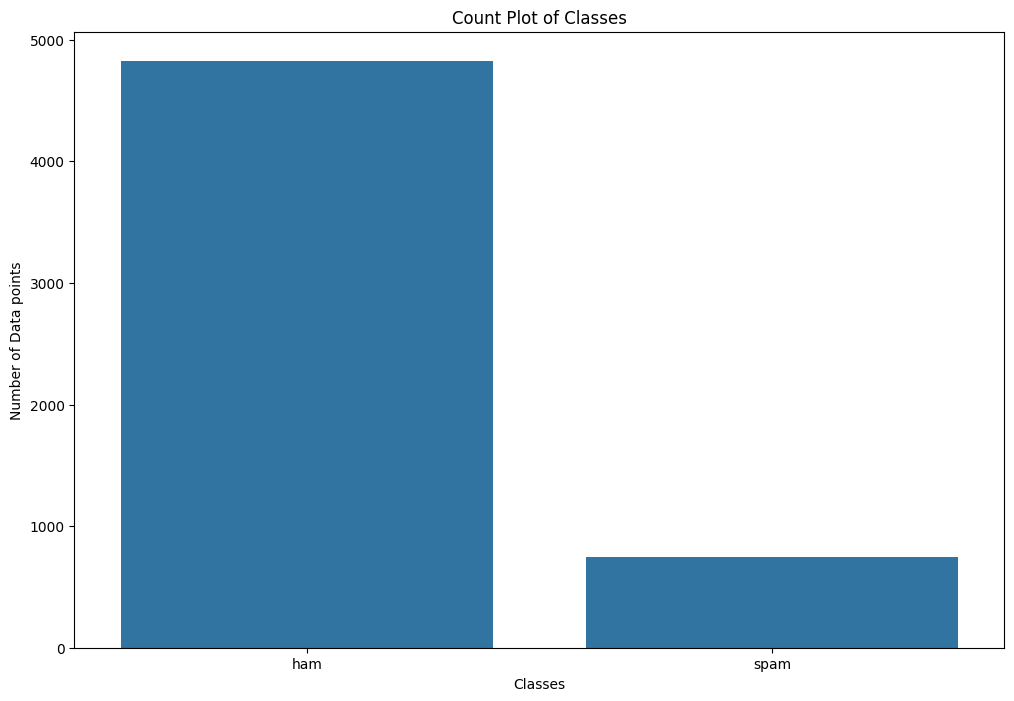

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"])
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points")

From the above countplot the data imbalance is quite evident.

### Feature engineering

Creating the following new features to better understand the structure and patterns within the SMS messages:

- **No_of_Characters**: Represents the total number of characters in each text message.
- **No_of_Words**: Indicates the number of words in each text message.
- **No_of_Sentences**: Captures the number of sentences in each text message.

In [ ]:
#nltk.download('punkt')
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

<Figure size 1200x800 with 0 Axes>

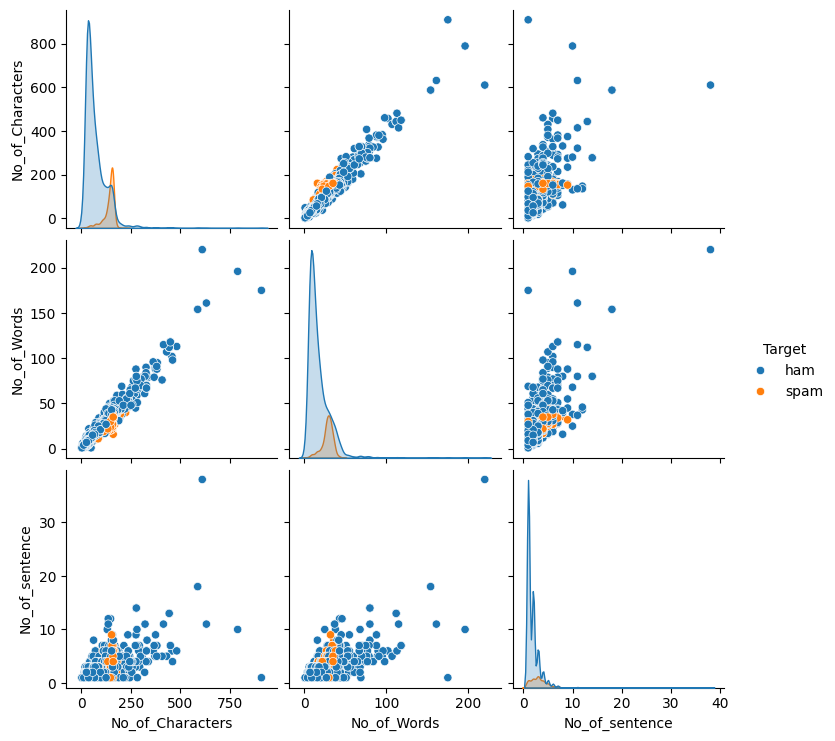

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target")
plt.show(fg)

**Note**: The pair plot reveals the presence of several outliers, all of which belong to the *ham* class. This observation is intriguing because it suggests that we might consider capping one of these features. Since these outliers primarily represent variations in the length of the SMS messages, applying a cap could help mitigate their impact on the model while maintaining the integrity of the dataset.

### OUTLIER DETECTION



In [ ]:
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

<Figure size 1200x800 with 0 Axes>

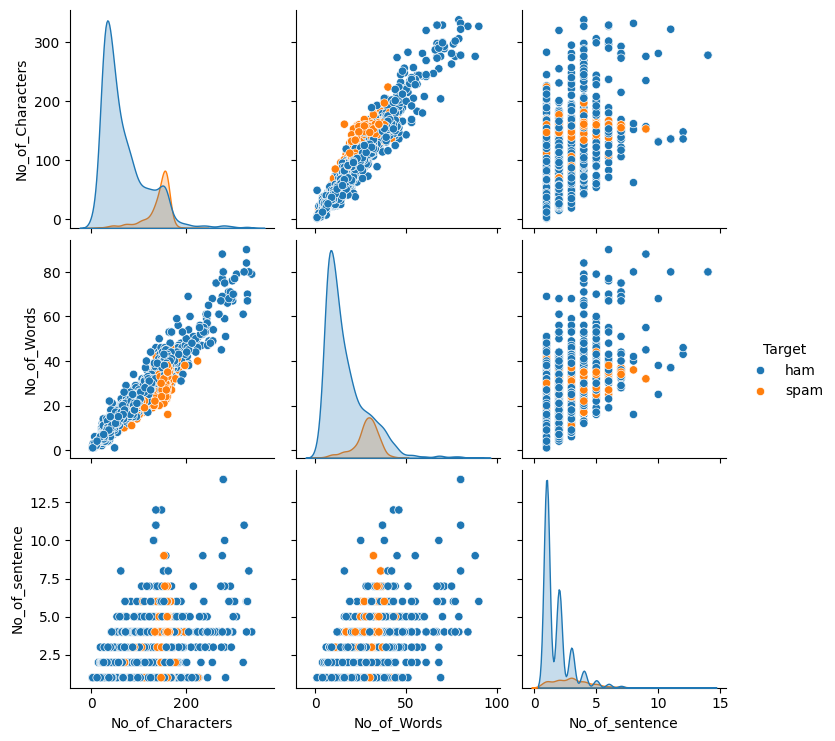

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target")
plt.show(fg)

## DATA PREPREPROCESSING

### CLEANING TEXT



The data cleaning process in Natural Language Processing (NLP) is crucial because computers do not inherently understand text; they see it merely as a collection of symbols. To enable effective processing, we must clean the data thoroughly.

### Data Cleaning Steps:

1. **Extracting Alphabetic Characters**: In this initial step, we will remove all punctuation and numbers, retaining only the alphabetic characters. This helps focus the analysis on the actual text content.

2. **Converting to Lowercase**: Next, we will convert all characters to lowercase. This standardization ensures that words are treated consistently, regardless of their original casing.

Once these steps are completed, the cleaned text will be ready for further processing and analysis in our spam classification model.

In [ ]:
print("The First 5",*data["Text"][:5], sep = "\n")

The First 5
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [ ]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("The First 5 Texts after cleaning",*data["Clean_Text"][:5], sep = "\n")

The First 5 Texts after cleaning
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


<ipython-input-12-8c6b0c04c1c8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Clean_Text"] = data["Text"].apply(Clean)


### TOKENIZATION

**Tokenization** is the process of breaking down complex data into smaller, manageable units called *tokens*. This step is essential for analyzing text data effectively.

In this notebook, I will focus on splitting the `Clean_Text` into individual words. This process allows us to transform sentences into words, making it easier to analyze the text for patterns and features relevant to our spam classification task. By tokenizing the cleaned text, we can facilitate further processing, such as feature extraction and model training.

In [ ]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("The First 5 Texts after Tokenizing",*data["Tokenize_Text"][:5], sep = "\n")

The First 5 Texts after Tokenizing
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


<ipython-input-13-1b58504b32c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)


### REMOVING STOPWORDS



**Stopwords** are commonly occurring words (such as "few," "is," "an," etc.) that, while important for sentence structure, do not significantly contribute to the meaningful analysis of text in Natural Language Processing (NLP). To reduce redundancy in our processing and enhance the model's performance, I will be removing these stopwords.

For this purpose, I will utilize the NLTK library, which provides a default set of stopwords. By eliminating these words from our dataset, we can focus on the more informative terms that will aid in the spam classification process.

In [ ]:
#nltk.download('stopwords')
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("The First 5 Texts after removing the stopwords:",*data["Nostopword_Text"][:5], sep = "\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


<ipython-input-15-20e4e933a8d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)


### LEMMATIZATION



**Stemming** is the process of reducing words to their root form by removing prefixes or suffixes, effectively tracing back to the word's etymology. This approach can simplify variations of a word, reflecting the evolution of languages, such as how English derives from Latin.

**Lemmatization**, on the other hand, also converts words to their root form but ensures that the resulting root word is a valid word in the target language—in this case, English. While both techniques aim to standardize word forms, lemmatization provides linguistically accurate outputs, making it preferable for many NLP applications.

In [ ]:
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("The First 5 Texts after lemitization",*data["Lemmatized_Text"][:5], sep = "\n")

[nltk_data] Downloading package wordnet to /root/nltk_data...


The First 5 Texts after lemitization
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


## VECTORIZE

**TF-IDF** in NLP stands for **Term Frequency-Inverse Document Frequency**, a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (or corpus). To analyze cleaned data effectively, we need to convert it into a numerical format, commonly referred to as **word embedding** or **word vectorization**.

### Definitions:
- **Term Frequency (TF)**: This represents the frequency of a term in a document divided by the total number of terms in the document.
  
$$
\text{TF} = \frac{\text{Frequency of a term in the document}}{\text{Total number of terms in the document}}
$$




- **Inverse Document Frequency (IDF)**: This measures how much information a word provides, calculated as the logarithm of the total number of documents divided by the number of documents containing the term \( t \).

$$
\text{IDF} = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents with term } t}\right)
$$

### Vectorization Steps:
1. **Creating a Corpus**: Generate a corpus of lemmatized text.
2. **Converting to Vector Form**: Use `TfidfVectorizer()` to transform the corpus into a numerical vector representation.
3. **Label Encoding**: Encode the classes in the **Target** column to prepare for model training.

By following these steps, we can effectively represent the textual data in a format suitable for machine learning algorithms, allowing for efficient classification of SMS messages as spam or ham.

In [ ]:
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("The First 5 lines in corpus :",*corpus[:5], sep = "\n")

The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype

dtype('float64')

In [ ]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

## MODEL BUILDING



Here are the steps involved in building the model for classifying SMS messages as spam or ham:

### Steps in Model Building:

1. **Setting Up Features and Target**:
   - We define our features (the input data) as **X** (the numerical representation of the text) and the target labels (spam or ham) as **y**. This organizes our data for training the models.

2. **Splitting the Data**:
   - We divide our dataset into two parts: a **training set** (used to train the models) and a **testing set** (used to evaluate the models' performance). This helps us see how well our models can predict new, unseen messages.

3. **Building a Pipeline of Models**:
   - We create a pipeline to apply different classifiers to our data. We will use four different algorithms:
     - **Naïve Bayes**: A simple and effective algorithm based on the Bayes theorem, often used for text classification.
     - **Random Forest Classifier**: A powerful ensemble method that combines multiple decision trees to improve accuracy and reduce overfitting.
     - **KNeighbors Classifier**: A method that classifies a message based on the majority class of its nearest neighbors in the feature space.
     - **Support Vector Machines (SVM)**: A robust classification technique that finds the best boundary to separate different classes.

4. **Fitting the Models**:
   - We train all the models using the training data, allowing them to learn the patterns associated with spam and ham messages.

5. **Cross-Validation for Accuracy**:
   - We perform cross-validation on the training set for each model to assess their accuracy. This involves splitting the training data into several smaller sets, training the model on some of these sets, and testing it on the others. This helps us understand how well each model will perform on new data.

By following these steps, we aim to identify which model is most effective at accurately classifying SMS messages as spam or ham.

In [ ]:
y = data["Target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
# Cossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.975438 
KNeighbours: 0.911450 
SVC: 0.974086 


## EVALUATING MODELS



### Testing the Models on the Test Set

1. **Accuracy Report**: Shows the percentage of correct predictions.
2. **Confusion Matrix**: Displays true positives, true negatives, false positives, and false negatives.

In [ ]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)

    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [29]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])
Results

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.830882,0.907631,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


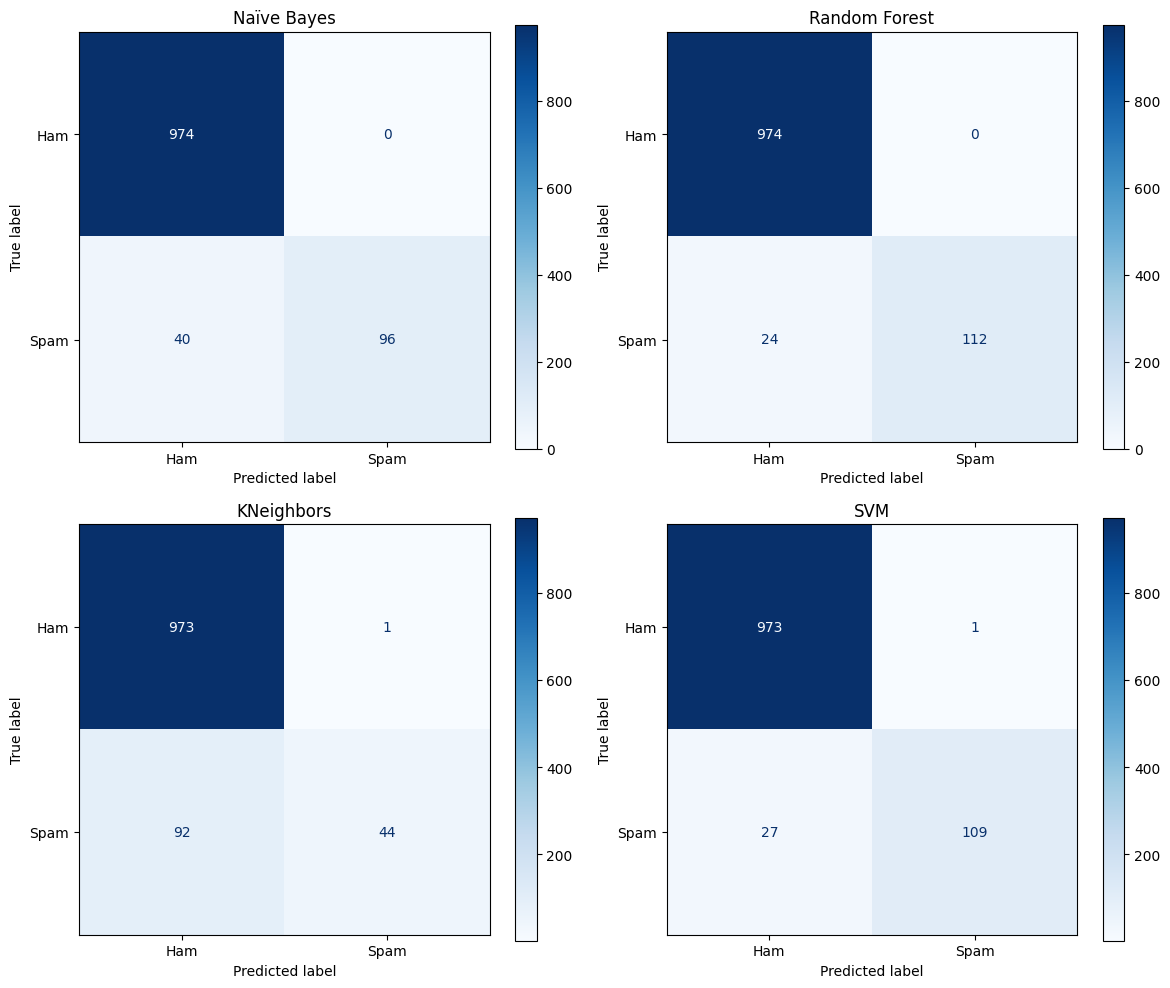

In [35]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifier_names = ['Naïve Bayes', 'Random Forest', 'KNeighbors', 'SVM']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a grid for subplots

for cls, name, ax in zip(classifiers, classifier_names, axes.flatten()):
    # Fit the model
    cls.fit(X_train, y_train)

    # Make predictions
    y_pred = cls.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot(ax=ax, cmap='Blues')  # You can change the color map
    ax.set_title(name)

plt.tight_layout()
plt.show()
